## Review topic modeling 2
#### Granularity: one topic per comment for a given listing

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

pd.set_option('display.max_columns', 100)

RANDOM_STATE= 42

In [2]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [5]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

import pyLDAvis.sklearn

### Prepare reviews

In [7]:
# load cleaned review dataset
review_df = pd.read_pickle('../data/data_cleaned/cleaned_review_with_polarity.zip')
print(review_df.shape)


(375173, 5)


In [8]:
# # use a small sample data to run
# sample_review = review_df.sample(200, random_state = RANDOM_STATE).reset_index(drop=True)
# sample_review.head(2)

In [9]:
# use all data to run
sample_review = review_df.copy()
sample_review.head(2)

,listing_id,date,reviewer_id,comments,polarity
0,6606,2009-07-17,18085,"The Urban Cottage is comfortable, beautiful, f...",0.9878
1,491958,2012-07-09,2595909,"Jay, Colleen, Mica & Gigi-dog were excellent h...",0.9979


### Preprocess reviews

In [10]:
def preprocess_text(text, stopwords = None, stem=False, lemma=False):
    # clean the text
    text = text.lower()
    # remove html and all other sybols 
    text = re.sub("(<.*?>)|([^0-9A-Za-z \t])"," ",text)
    
    # tokenize the text
    text = word_tokenize(text)     
    # remove stopwords and non alpha words
    text = [word for word in text if word not in stopwords]
    
    # get the root of word
    if stem == True:   
        stemmer = PorterStemmer()
        text = [stemmer.stem(word) for word in text]   
    
    # normalize the word  
    if lemma == True:
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text]
        
    # list to string
    text = ' '.join(text)  
    
    return text

In [11]:
# create a function to pull out specific part of speech from a string of text
def get_adjs(text):
    '''Given a string of text, tokenize the text and pull out only the adjectives.'''
    text_list = text.split()
    is_adjs = lambda pos: pos[:2] == 'JJ'
    all_adjs = [word for (word, pos) in pos_tag(text_list) if is_adjs(pos)] 
    return ' '.join(all_adjs)

def get_nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    text_list = text.split()
    is_noun = lambda pos: pos[:2] == 'NN'
    all_nouns = [word for (word, pos) in pos_tag(text_list) if is_noun(pos)] 
    return ' '.join(all_nouns)

def get_nouns_adjs(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    text_list = text.split()
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    nouns_adj = [word for (word, pos) in pos_tag(text_list) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [12]:
# prepare stopword set
added_stopwords = ["can't",'t', 'us', 'say','would', 'also','within','stay', 'since']
nltk_STOPWORDS = set(stopwords.words("english"))
nltk_STOPWORDS.update(added_stopwords)

In [13]:
%%time
# get cleaned comments
sample_review['cleaned_comments'] = sample_review['comments'] \
                                    .apply(lambda x: preprocess_text(
                                            x,stopwords = nltk_STOPWORDS, 
                                            stem=False, lemma=True))

CPU times: user 1min 52s, sys: 536 ms, total: 1min 52s
Wall time: 1min 54s


In [14]:
%%time
# only keep nouns and adjs from the cleaned_comments tokens
sample_review['comments_nouns_adjs'] = sample_review['cleaned_comments'].apply(get_nouns_adjs)

CPU times: user 7min 31s, sys: 8.75 s, total: 7min 40s
Wall time: 7min 41s


In [15]:
sample_review.head(3)

,listing_id,date,reviewer_id,comments,polarity,cleaned_comments,comments_nouns_adjs
0,6606,2009-07-17,18085,"The Urban Cottage is comfortable, beautiful, f...",0.9878,urban cottage comfortable beautiful fun really...,urban cottage comfortable beautiful fun conven...
1,491958,2012-07-09,2595909,"Jay, Colleen, Mica & Gigi-dog were excellent h...",0.9979,jay colleen mica gigi dog excellent host welco...,jay colleen mica gigi dog excellent host warm ...
2,491958,2012-07-12,206203,Wonderful place in a great neighborhood near m...,0.9851,wonderful place great neighborhood near much b...,wonderful place great neighborhood much best s...


### NMF for topic modeling

In [20]:
# prepare clean corpus

review_corpus = sample_review['comments_nouns_adjs'].values.tolist()
print(len(review_corpus))

375173


In [21]:
# prepare stopword set
added_STOPWORDS = ["place",'great', 'good', 'nice','b','everything','need', 'thank','thanks']
nmf_STOPWORDS = set(stopwords.words("english"))
nmf_STOPWORDS.update(added_STOPWORDS)

In [22]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
                                min_df=2,  
                                max_df=0.9, 
                                stop_words=nmf_STOPWORDS) 

tfidf_documents = tfidf_vectorizer.fit_transform(review_corpus)


# get feature name and vocabulary
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
tfidf_vocab = tfidf_vectorizer.vocabulary_

print(tfidf_documents.shape)
print("Number of unique terms in vocabulary:", len(tfidf_feature_names))

(375173, 17476)
Number of unique terms in vocabulary: 17476


In [23]:
# create topic using NMF
n_topics=4

nmf = NMF(n_components=n_topics, random_state=RANDOM_STATE)
nmf.fit(tfidf_documents )
nmf_topic_components = nmf.components_

/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/Users/abbyz/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

In [24]:
# display top n words in each topic

num_top_words = 20

def display_topics(model, feature_names, no_top_words):
    
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)
        
display_topics(nmf, tfidf_feature_names, num_top_words)

topic 0: ['seattle', 'space', 'easy', 'perfect', 'home', 'neighborhood', 'beautiful', 'house', 'restaurant', 'downtown', 'apartment', 'area', 'time', 'quiet', 'spot', 'view', 'distance', 'lot', 'little', 'walk']
topic 1: ['location', 'perfect', 'convenient', 'excellent', 'awesome', 'apartment', 'space', 'communication', 'value', 'fantastic', 'view', 'central', 'price', 'amenity', 'easy', 'check', 'condo', 'distance', 'wonderful', 'cute']
topic 2: ['host', 'wonderful', 'responsive', 'helpful', 'communication', 'excellent', 'super', 'awesome', 'communicative', 'fantastic', 'kind', 'recommend', 'friendly', 'house', 'question', 'home', 'experience', 'thoughtful', 'amazing', 'gracious']
topic 3: ['clean', 'comfortable', 'super', 'quiet', 'cozy', 'convenient', 'bed', 'spacious', 'easy', 'room', 'cute', 'communication', 'apartment', 'space', 'modern', 'stylish', 'check', 'comfy', 'amenity', 'private']


In [25]:
# get document weights per topic

def get_best_document_per_topic(review_corpus, model, document_matrix):

    output = model.transform(document_matrix)
    # print("NMF transform output:\n", nmf_output)
    best_document_per_topic = np.argsort(output, axis = 0)[::-1]
    for topic_index in range(0, n_topics):
        best_index = best_document_per_topic[0, topic_index]
        print("Highest topic", topic_index, "weight is document", 
              best_index, ":", review_corpus[best_index][0:30])


get_best_document_per_topic(review_corpus,nmf,tfidf_documents)

Highest topic 0 weight is document 183423 : nice cozy room shop restaurant
Highest topic 1 weight is document 213154 : great location everything
Highest topic 2 weight is document 110921 : great place host
Highest topic 3 weight is document 125294 : clean


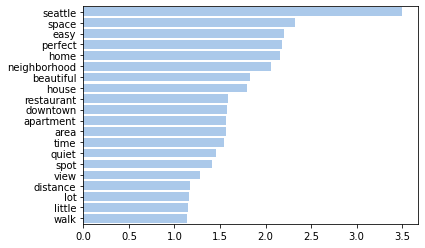

In [26]:
# display a bar chart of top_n topic weights

def top_n_topic_weights(topic_components,feature_names, topic_index):

    vocab = np.array(feature_names)
    top_term_indices = np.array(np.argsort(topic_components[topic_index, :])[::-1])[0:20]

    term_strings = vocab[top_term_indices]
    term_weights = topic_components[topic_index, top_term_indices]

    sns.set_color_codes("pastel")
    sns.barplot(x=term_weights, y=term_strings, label="Weight", color="b")

    plt.show()

# show the topic weight for topic 1
topic_index = 0
top_n_topic_weights(nmf_topic_components, tfidf_feature_names, topic_index)

### Interpret topics 

In [47]:
# the found 4 topics
display_topics(nmf, tfidf_feature_names, num_top_words)

topic 0: ['seattle', 'space', 'easy', 'perfect', 'home', 'neighborhood', 'beautiful', 'house', 'restaurant', 'downtown', 'apartment', 'area', 'time', 'quiet', 'spot', 'view', 'distance', 'lot', 'little', 'walk']
topic 1: ['location', 'perfect', 'convenient', 'excellent', 'awesome', 'apartment', 'space', 'communication', 'value', 'fantastic', 'view', 'central', 'price', 'amenity', 'easy', 'check', 'condo', 'distance', 'wonderful', 'cute']
topic 2: ['host', 'wonderful', 'responsive', 'helpful', 'communication', 'excellent', 'super', 'awesome', 'communicative', 'fantastic', 'kind', 'recommend', 'friendly', 'house', 'question', 'home', 'experience', 'thoughtful', 'amazing', 'gracious']
topic 3: ['clean', 'comfortable', 'super', 'quiet', 'cozy', 'convenient', 'bed', 'spacious', 'easy', 'room', 'cute', 'communication', 'apartment', 'space', 'modern', 'stylish', 'check', 'comfy', 'amenity', 'private']


After trying different number of topics on the nouns and adjectives of the reviews, we found 4 topics made the most sense. Below are the topics we interpreted.

From the top 20 terms in each topic, we found that:

- Topic 0: review about overall neighborhood.
- Topic 1: review about location convenience.
- Topic 2: review about host communication.
- Topic 3: review about housing experience.

#### Get topic label per review document

In [27]:
## add topic label to the review dataframe

sample_review['review_topic'] = nmf.transform(tfidf_documents).argmax(axis=1)

In [37]:
topic_labels = [0,1,2,3]
topic_labels_interpreted = ['Neighborhood Overall', 'Location Convenience', 'Host Communication', 'Housing Experience']
topic_label_dict = dict(zip(topic_labels,topic_labels_interpreted))
topic_label_dict

{0: 'Neighborhood Overall',
 1: 'Location Convenience',
 2: 'Host Communication',
 3: 'Housing Experience'}

In [38]:
sample_review['review_topic_interpreted'] = sample_review['review_topic'].map(topic_label_dict)

In [39]:
sample_review.review_topic_interpreted.value_counts()

Neighborhood Overall    202340
Host Communication       62960
Location Convenience     59554
Housing Experience       50319
Name: review_topic_interpreted, dtype: int64

In [40]:
sample_review.isna().sum()

listing_id                  0
date                        0
reviewer_id                 0
comments                    0
polarity                    0
cleaned_comments            0
comments_nouns_adjs         0
review_topic                0
review_topic_interpreted    0
dtype: int64

In [41]:
print(sample_review.shape)
sample_review.head(2)

(375173, 9)


,listing_id,date,reviewer_id,comments,polarity,cleaned_comments,comments_nouns_adjs,review_topic,review_topic_interpreted
0,6606,2009-07-17,18085,"The Urban Cottage is comfortable, beautiful, f...",0.9878,urban cottage comfortable beautiful fun really...,urban cottage comfortable beautiful fun conven...,0,Neighborhood Overall
1,491958,2012-07-09,2595909,"Jay, Colleen, Mica & Gigi-dog were excellent h...",0.9979,jay colleen mica gigi dog excellent host welco...,jay colleen mica gigi dog excellent host warm ...,0,Neighborhood Overall


#### Plot topics for a given listing

In [42]:
import altair as alt

In [43]:
def plot_listing_review_topics(df,col, listing_id):
    if listing_id in df['listing_id'].values:
        sub_df = df[df['listing_id'] == listing_id]
        plot = alt.Chart(sub_df).mark_bar().encode(
                        y=alt.Y('review_topic_interpreted:O', sort='-x'),
                        x='count():Q',
                        color=alt.Color('listing_id:O', scale=alt.Scale(scheme= 'dark2'))
                    ).properties(
                        width=500,
                        height=300
                    ).interactive()
        return plot
    else:
        print("Oops, this listing currently has no comments.")

selected_listing_id = sample_review['listing_id'].unique()[0]
plot_listing_review_topics(sample_review,'review_topic_interpreted', selected_listing_id)

alt.Chart(...)

#### Save dataset

In [44]:
# save the dataset that contains the preprocessed nouns and adjectives and topics
# of all the listing comments for plots in the streamlit app.
sample_review.to_pickle('../data/data_cleaned/cleaned_review_with_polarity_and_topic.zip')

In [45]:
# # check the saved dataset
df = pd.read_pickle('../data/data_cleaned/cleaned_review_with_polarity_and_topic.zip')
print(df.shape)
df.head(2)

(375173, 9)


,listing_id,date,reviewer_id,comments,polarity,cleaned_comments,comments_nouns_adjs,review_topic,review_topic_interpreted
0,6606,2009-07-17,18085,"The Urban Cottage is comfortable, beautiful, f...",0.9878,urban cottage comfortable beautiful fun really...,urban cottage comfortable beautiful fun conven...,0,Neighborhood Overall
1,491958,2012-07-09,2595909,"Jay, Colleen, Mica & Gigi-dog were excellent h...",0.9979,jay colleen mica gigi dog excellent host welco...,jay colleen mica gigi dog excellent host warm ...,0,Neighborhood Overall


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>